# Hyperparameters

In [1]:
IS_TRAINING_MODE = True

# training data paramters
TRAINING_PERCENT_PARAMETER = 0.15 if IS_TRAINING_MODE else 0.015

# Development Parameters
DEBUG_PARAMETER = True
PARAM_FINAL_IMAGES = False
PARAM_GENERATE_CONFIDENCE_MATRIX = True

# Hyper parameters
logistic_regression__C = 1.0
logistic_regression__class_weight = None
logistic_regression__fit_intercept = True
logistic_regression__penalty = None
logistic_regression__solver = 'lbfgs'
kneighbors__algorithm = 'auto'
kneighbors__n_neighbors = 1
kneighbors__weights = None
decision_tree__criterion = 'gini'
decision_tree__max_depth = 1
decision_tree__max_features = None

# Initializing Data

## Preparing Data

In [2]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.utils import shuffle

from sklearn import tree

import pandas as pd
import numpy as np
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge

# HalvingGridSearchCV is experimental and the API might change without any deprecation cycle
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import auc as skl_auc
from sklearn.model_selection import GridSearchCV


### Load the Data

In [3]:
plays_path = '/Users/davidstange/Development/github/davestange/data/big_data_bowl_2025/plays.csv'
plays = pd.read_csv(plays_path)

plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,2022110604,1051,(12:49) (Shotgun) T.Lawrence pass incomplete s...,2,3,4,JAX,LV,JAX,31,...,0,-0.024741,0.024741,-1.391687,True,NaN,NaN,0,Cover-2,Zone
16120,2022103005,3492,(12:32) (Shotgun) K.Cousins pass incomplete de...,4,1,10,MIN,ARI,MIN,25,...,0,-0.026580,0.026580,-0.503208,True,NaN,NaN,0,Cover-3,Zone
16121,2022092502,2337,(9:59) (Shotgun) P.Mahomes scrambles right end...,3,1,10,KC,IND,IND,13,...,10,-0.013790,0.013790,1.073898,True,NaN,NaN,0,Quarters,Zone
16122,2022091809,719,(:45) C.Rush pass incomplete deep right to C.L...,1,1,10,DAL,CIN,CIN,47,...,0,-0.011561,0.011561,-0.522397,True,UNDEFINED,NaN,0,Cover-3,Zone


## Readying the dataset

In [4]:
def get_position_features(s: pd.Series) -> pd.Series:
    ### determine wr, te, rb based on alignment; WRxTE
    wr_count = te_count = rb_count = 0
    extra_ol = s.offenseFormation == "JUMBO"
    if not isinstance(s.receiverAlignment, float):
        alignment = s.receiverAlignment.split('x')
        if len(alignment):
            wr_count = int(alignment[0])
            te_count = int(alignment[1])
            rb_count = 5 - wr_count - te_count
            if extra_ol and rb_count > 1:
                rb_count -= 1 

    return pd.Series([wr_count, te_count, rb_count, extra_ol], ['wr_count', 'te_count', 'rb_count', 'extra_ol'])
def get_time_features(s: pd.Series) -> pd.Series:
    ### determine total time remaining, is overtime, or within two mins 
    two_min_1st_half = 32 * 60
    two_min_2st_half = 2 * 60
    two_min_overtime = 68 * 60
    
    quarter = int(s.quarter)
    secs_remaining = math.nan
    is_inside_two_mins = is_overtime = False
    quarter_clock = s.gameClock.split(':')
    if len(quarter_clock) == 2:
        secs_in_quarter = int(quarter_clock[0]) * 60 + int(quarter_clock[1])
        if quarter <= 4:
            secs_remaining = (4 - quarter) * 15 * 60 + secs_in_quarter
        else:
            secs_remaining = secs_in_quarter
            is_overtime = True
        is_inside_two_mins = secs_in_quarter <= 120 and (quarter == 2 or quarter >= 4)

    return pd.Series([secs_remaining, is_inside_two_mins, is_overtime], ['secs_remaining', 'is_inside_two_mins', 'is_overtime'])

# v1 result - just sneak, kneel, spikie, pass, or run
plays['play_result'] = plays.apply(lambda p: 
                                   'run' if p.qbSneak == True else 
                                   'run' if p.qbKneel == True else 
                                   'pass' if p.qbSpike == True else 
                                   'pass' if p.isDropback == True else 
                                   'run', axis = 1)

# offenseFormation is NaN for qb kneels or spikes
plays['offense_formation'] = plays.apply(lambda p: 
                                   'UNKNOWN' if p.qbKneel == True else
                                   'UNKNOWN' if p.qbSpike == True else
                                   p.offenseFormation, axis = 1)

# get position counts (TE, WR, etc)
tmp = plays.apply(get_position_features, axis=1)
plays['wr_count'] = tmp['wr_count']
plays['te_count'] = tmp['te_count']
plays['rb_count'] = tmp['rb_count']
plays['extra_ol'] = tmp['extra_ol']

tmp = plays.apply(get_time_features, axis=1)
plays['secs_remaining'] = tmp['secs_remaining']
plays['is_inside_two_mins'] = tmp['is_inside_two_mins']
plays['is_overtime'] = tmp['is_overtime']

# # preSnapHomeScore, preSnapVisitorScore, need Home/Away 
# plays['off_score_lead'] = plays.apply(...)

# # preSnapHomeTeamWinProbability	preSnapVisitorTeamWinProbability, need Home/Away 
# plays['off_win_probability'] = plays.apply(...)

plays['off_yards_to_goal'] = plays.apply(lambda p: 100 - int(p.yardlineNumber) if p.yardlineSide == p.possessionTeam else int(p.yardlineNumber), axis = 1)
df = plays

## Prepare the training set

In [5]:
TARGET_FEATURE = 'play_result'
TRAINING_FEATURES = ['down', 'yardsToGo',                                                       # down and distance
                     'quarter', 'secs_remaining', 'is_inside_two_mins', 'is_overtime',          # game time
                     'wr_count', 'te_count', 'rb_count', 'extra_ol', 'offense_formation',       # formations
                     TARGET_FEATURE]

# set transformer of remaining categorical features
col_trans = make_column_transformer(
    (OneHotEncoder(drop = 'if_binary'), ['offense_formation']),
    remainder='passthrough')

In [6]:
tmp = df[TRAINING_FEATURES]
X_train, X_test, y_train, y_test = train_test_split(tmp.drop(TARGET_FEATURE, axis = 1), 
                                                    tmp[TARGET_FEATURE],
                                                    train_size=TRAINING_PERCENT_PARAMETER,
                                                    random_state=27,
                                                    stratify = df[TARGET_FEATURE])
if DEBUG_PARAMETER:
    print(f"The training set has {len(y_train)} rows")
    print(f"The test set has {len(y_test)} rows")
    print(f"The target feature is {TARGET_FEATURE} and the {len(X_train.columns)} training columns are {[x for x in X_train.columns]}")

The training set has 2418 rows
The test set has 13706 rows
The target feature is play_result and the 11 training columns are ['down', 'yardsToGo', 'quarter', 'secs_remaining', 'is_inside_two_mins', 'is_overtime', 'wr_count', 'te_count', 'rb_count', 'extra_ol', 'offense_formation']


## Automation Layer

In [7]:
def create_confusion_matrix(model_name, predictions, y_test):
    cm = confusion_matrix(predictions, y_test)
    sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 20}, cbar = False)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion matrix for {model_name}')
    sns.set(font_scale = 2)
    
def create_confusion_matrix_2(model_name, predictions, y_test):
    cm = confusion_matrix(predictions, y_test)
    disp1 = ConfusionMatrixDisplay(cm)
    disp1.plot()
    
def create_roc_curve(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc_value = skl_auc(fpr, tpr)

    disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp2.plot()

all_best_params = {}
def print_best_params(name, best_params):
    if IS_TRAINING_MODE:
        return
    print(f"======== Best Params for {name} ========")
    for key in best_params:
        value = best_params[key]
        if not isinstance(value, str):
            print(f"{key} = {value}")
        else:
            print(f"{key} = '{value}'")

def append_best_params(name, best_params):
    all_best_params.update(best_params)
    print_best_params(name, best_params)

all_runs = []
best_run = None
class ModelTrainer:
    def __init__(self, model_name, actual_model, generate_charts=True):
        self.start_time = time.time()
        self.model_name = model_name
        self.model = actual_model
        self.generate_charts = False #generate_charts
        self.training_features = None
        self.train_time = None
        self.train_accuracy = None
        self.test_accuracy = None
        # self.predictions = None
        
    def elapsed(self):
        elapsed_time = time.time() - self.start_time
        return f"{elapsed_time:.4f} secs"
    
    def model_predict(self, X, is_continuous):
        prediction = self.model.predict(X)
        if is_continuous:
            prediction = (prediction >= 0.5).astype(int)
        return prediction
    
    def chart_roc_and_confusion(self, is_continuous):
        fig, ax = plt.subplots(1, 2)
        if PARAM_FINAL_IMAGES:
            fig.set_size_inches(20, 12)
        else:
            fig.set_size_inches(15, 5)

        preds = self.model_predict(X_test, is_continuous)

        # Confusion Matrix
        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            conf_matrix = confusion_matrix(y_test, preds)
            disp1 = ConfusionMatrixDisplay(conf_matrix)
            disp1.plot(ax=ax[0])

        # ROC Curve
        y_score = None
        if not is_continuous:
            y_score = self.model.predict_proba(X_test)[:, 1]
        else:
            y_score = self.model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label='run') # 
        roc_auc_value = skl_auc(fpr, tpr)

        disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
        disp2.plot(ax=ax[1])

    def run_old(self, is_continuous=False):
        training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1
        self.model.fit(X_train, y_train)
        train_accuracy = accuracy_score(self.model_predict(X_train, is_continuous), y_train)
        self.predictions = self.model_predict(X_test, is_continuous)
        test_accuracy = accuracy_score(self.predictions, y_test) 
        all_runs.append(f"| {self.model_name} | {training_features} | {self.elapsed()} | {train_accuracy:4f} | {test_accuracy:4f} |")

        # ax = create_plots(2)
        # create_confusion_matrix_2(self.model_name, self.predictions, y_test, ax[0])
        # create_roc_curve(self.model, X_test, y_test, ax[1])
        if self.generate_charts:
            self.chart_roc_and_confusion(is_continuous)
    
    def run(self, is_continuous=False):
        global best_run
        if not IS_TRAINING_MODE:
            print("Not training models - IS_TRAINING_MODE=False")
            return
        training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1
        self.model.fit(X_train, y_train)
        predictions = self.model.predict(X_test)
        train_accuracy = accuracy_score(self.model.predict(X_train), y_train)
        test_accuracy = accuracy_score(predictions, y_test) 
        self.training_features = training_features
        self.train_time = self.elapsed()
        self.train_accuracy = train_accuracy
        self.test_accuracy = test_accuracy
        all_runs.append(self)
        if best_run is None or self.test_accuracy > best_run.test_accuracy:
            best_run = self

        if PARAM_GENERATE_CONFIDENCE_MATRIX:
            self.chart_roc_and_confusion(False)

def optimize_model_params(pipeline, parameters_to_try):
    if IS_TRAINING_MODE:
        print("Not optimizing hyper parameters - IS_TRAINING_MODE=True")
        return
    model_finder = GridSearchCV(estimator = pipeline, 
                                param_grid = parameters_to_try, 
                                scoring = "accuracy",
                                n_jobs=-1,      # parallelization
                                cv = 5)
    model_finder.fit(X_train, y_train)
    append_best_params("LogisticRegression", model_finder.best_params_)

def show_run_output():
    if not IS_TRAINING_MODE:
        return
    print(f"*Best Run is {best_run.test_accuracy:4f} from {best_run.model_name}*\n")
    print("| Model | Features | Train Time | Train Accuracy | Test Accuracy |")
    print("| ----- | -------- | ---------- | -------------  | -----------   |")
    for r in all_runs:
        print(f"| {r.model_name} | {r.training_features} | {r.train_time} | {r.train_accuracy:4f} | {r.test_accuracy:4f} |")


# Determine Hyperparameters

### Logistic Regression

In [8]:
PARAM_VERBOSE = False
pipeline = Pipeline([
    ('transformer', col_trans),
    ('logistic_regression', LogisticRegression(max_iter=10000))
])
parameters_to_try = {
    'logistic_regression__fit_intercept': [True, False],
    'logistic_regression__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'logistic_regression__C': [1.0, 100.0, 10000.0],
    'logistic_regression__class_weight': [None, 'balanced'],
    'logistic_regression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### K-Nearest Neighbors

In [9]:
pipeline = Pipeline([
    ('transformer', col_trans),
    ('kneighbors', KNeighborsClassifier())
])
parameters_to_try = {
    'kneighbors__n_neighbors': np.array(range(1, 20)),
    'kneighbors__weights': [None, 'uniform', 'distance'],
    'kneighbors__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'kneighbors__leaf_sizeint': ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Decision Tree

In [10]:
pipeline = Pipeline([
    ('transformer', col_trans),
    ('decision_tree', DecisionTreeClassifier(criterion='entropy'))
])
parameters_to_try = {
    'decision_tree__criterion': ['gini', 'entropy', 'log_loss'],
    'decision_tree__max_depth': np.array(range(1, 20)),
    'decision_tree__max_features': [None, 'sqrt', 'log2'],
}

optimize_model_params(pipeline, parameters_to_try)

Not optimizing hyper parameters - IS_TRAINING_MODE=True


### Support Vector Machines

In [11]:
# pipeline = Pipeline([
#     ('transformer', col_trans),
#     ('regression', SVC(probability=False,        # avoid applying expensive Platt's calibration internally
#                        ))
# ])
# parameters_to_try = {
#     'regression__C': [0.1, 10, 1000], 
# 	'regression__gamma': [0.1, 10, 100], # 1, 0.1, 0.01, 0.001, 0.0001
# 	'regression__kernel': ['poly']
# }

# # scoring on HalvingGridSearchCV is failing due to wild
# # UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan.
# # model_finder = HalvingGridSearchCV(estimator = pipeline, 
# #                                    param_grid = parameters_to_try, 
# #                                    scoring = "accuracy",
# #                                    verbose=1)

# # switching to 
# model_finder = GridSearchCV(estimator = pipeline, 
#                             param_grid = parameters_to_try, 
#                             scoring = "accuracy",
#                             cv = 3,
#                             n_jobs=-1,      # parallelization
#                             verbose=99)
# model_finder.fit(X_train, y_train)
# append_best_params("LogisticRegression", model_finder.best_params_)

### Ridge

In [12]:
# pipeline = Pipeline([
#     ('transformer', col_trans),
#     ('ridge', Ridge)
# ])
# parameters_to_try = {
#     'ridge__alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
# }

# model_finder = GridSearchCV(estimator = pipeline, 
#                             param_grid = parameters_to_try, 
#                             scoring = "accuracy",
#                             n_jobs=-1,      # parallelization
#                             cv = 5)
# model_finder.fit(X_train, y_train)
# append_best_params("Ridge", model_finder.best_params_)

# Runtime Models

### Baseline

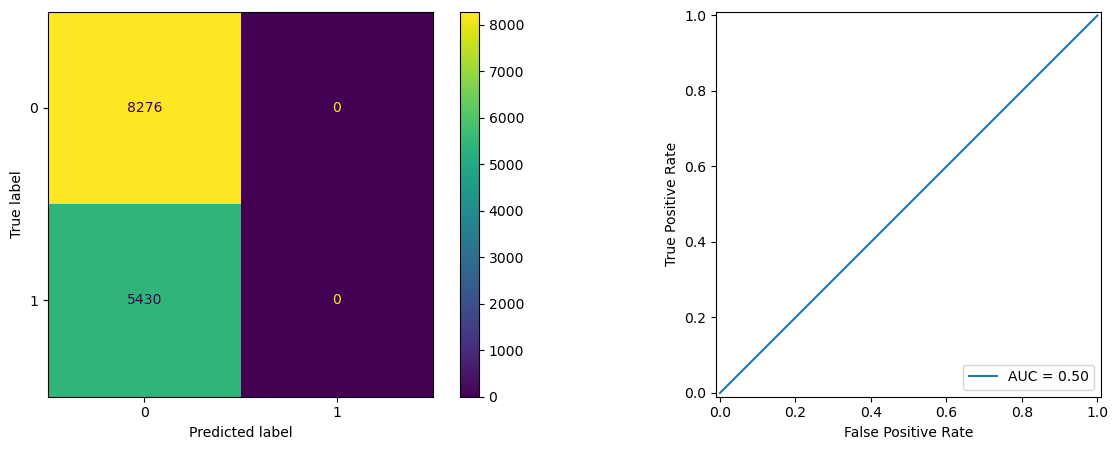

In [13]:
modeller = ModelTrainer(
    "Dummy", 
    DummyClassifier()
)
modeller.run()

### Logistic Regression

/opt/anaconda3/envs/predict_plays/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


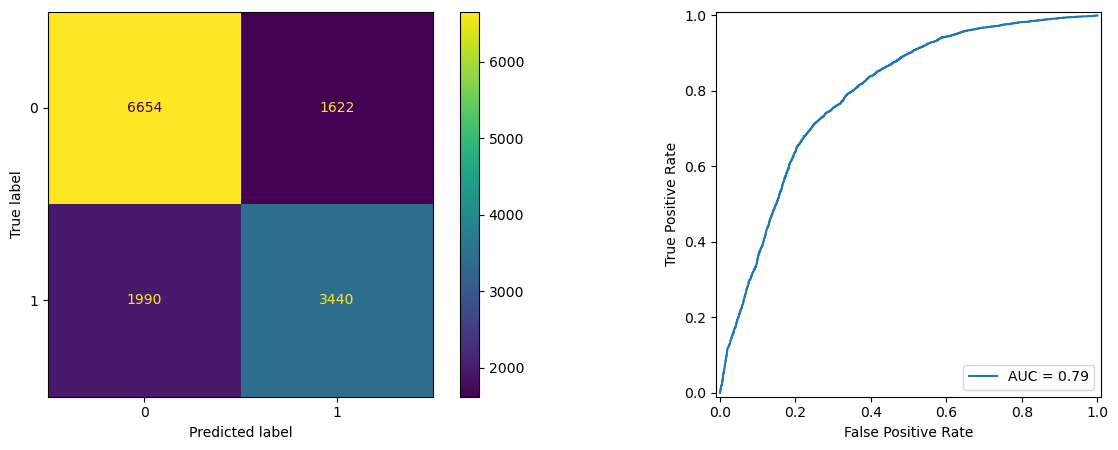

In [14]:
model_name = f"LogisticRegression (fit_intercept = {logistic_regression__fit_intercept}, penalty = {logistic_regression__penalty}, C = {logistic_regression__C}, class_weight = {logistic_regression__class_weight}, solver = {logistic_regression__solver})"
model = LogisticRegression(fit_intercept = logistic_regression__fit_intercept,
                           penalty = logistic_regression__penalty,
                           C = logistic_regression__C,
                           class_weight = logistic_regression__class_weight,
                           solver = logistic_regression__solver)
ModelTrainer(model_name, 
             Pipeline([
                 ('transformer', col_trans), 
                 ('regression', model)
            ])).run()

### K-Nearest Neighbors

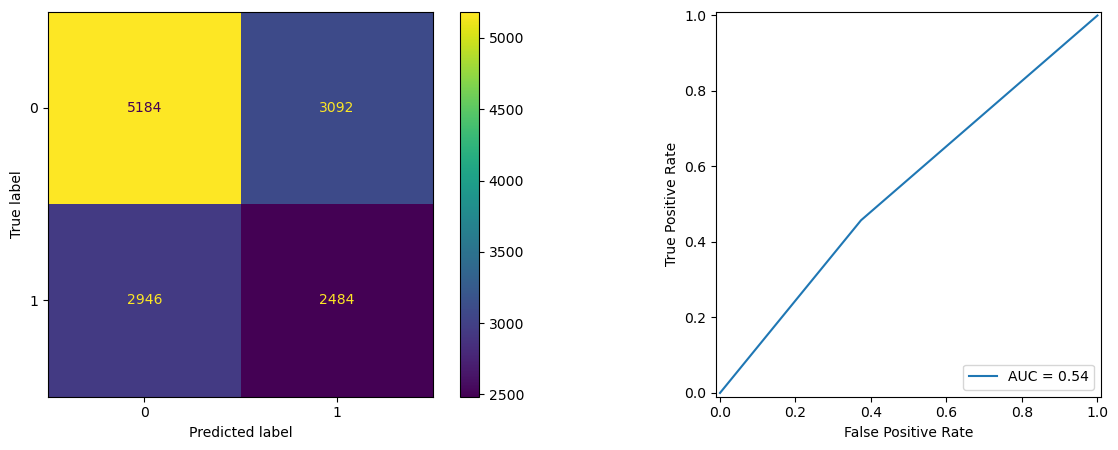

In [15]:
model_name = f"K-Nearest Neighbors (algorithm = {kneighbors__algorithm}, n_neighbors = {kneighbors__n_neighbors}, weights = {kneighbors__weights})"
model = KNeighborsClassifier(algorithm = kneighbors__algorithm,
                             n_neighbors = kneighbors__n_neighbors,
                             weights = kneighbors__weights)
ModelTrainer(model_name, 
             Pipeline([
                 ('transformer', col_trans), 
                 ('regression', model)
            ])).run()

### Decision Tree

Text(0.5, 0.98, 'Decision Tree Classifier')

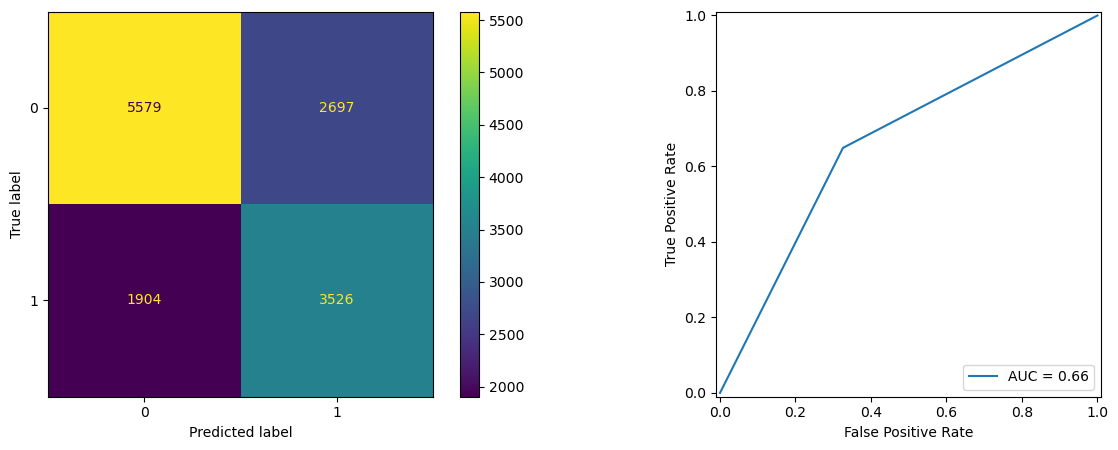

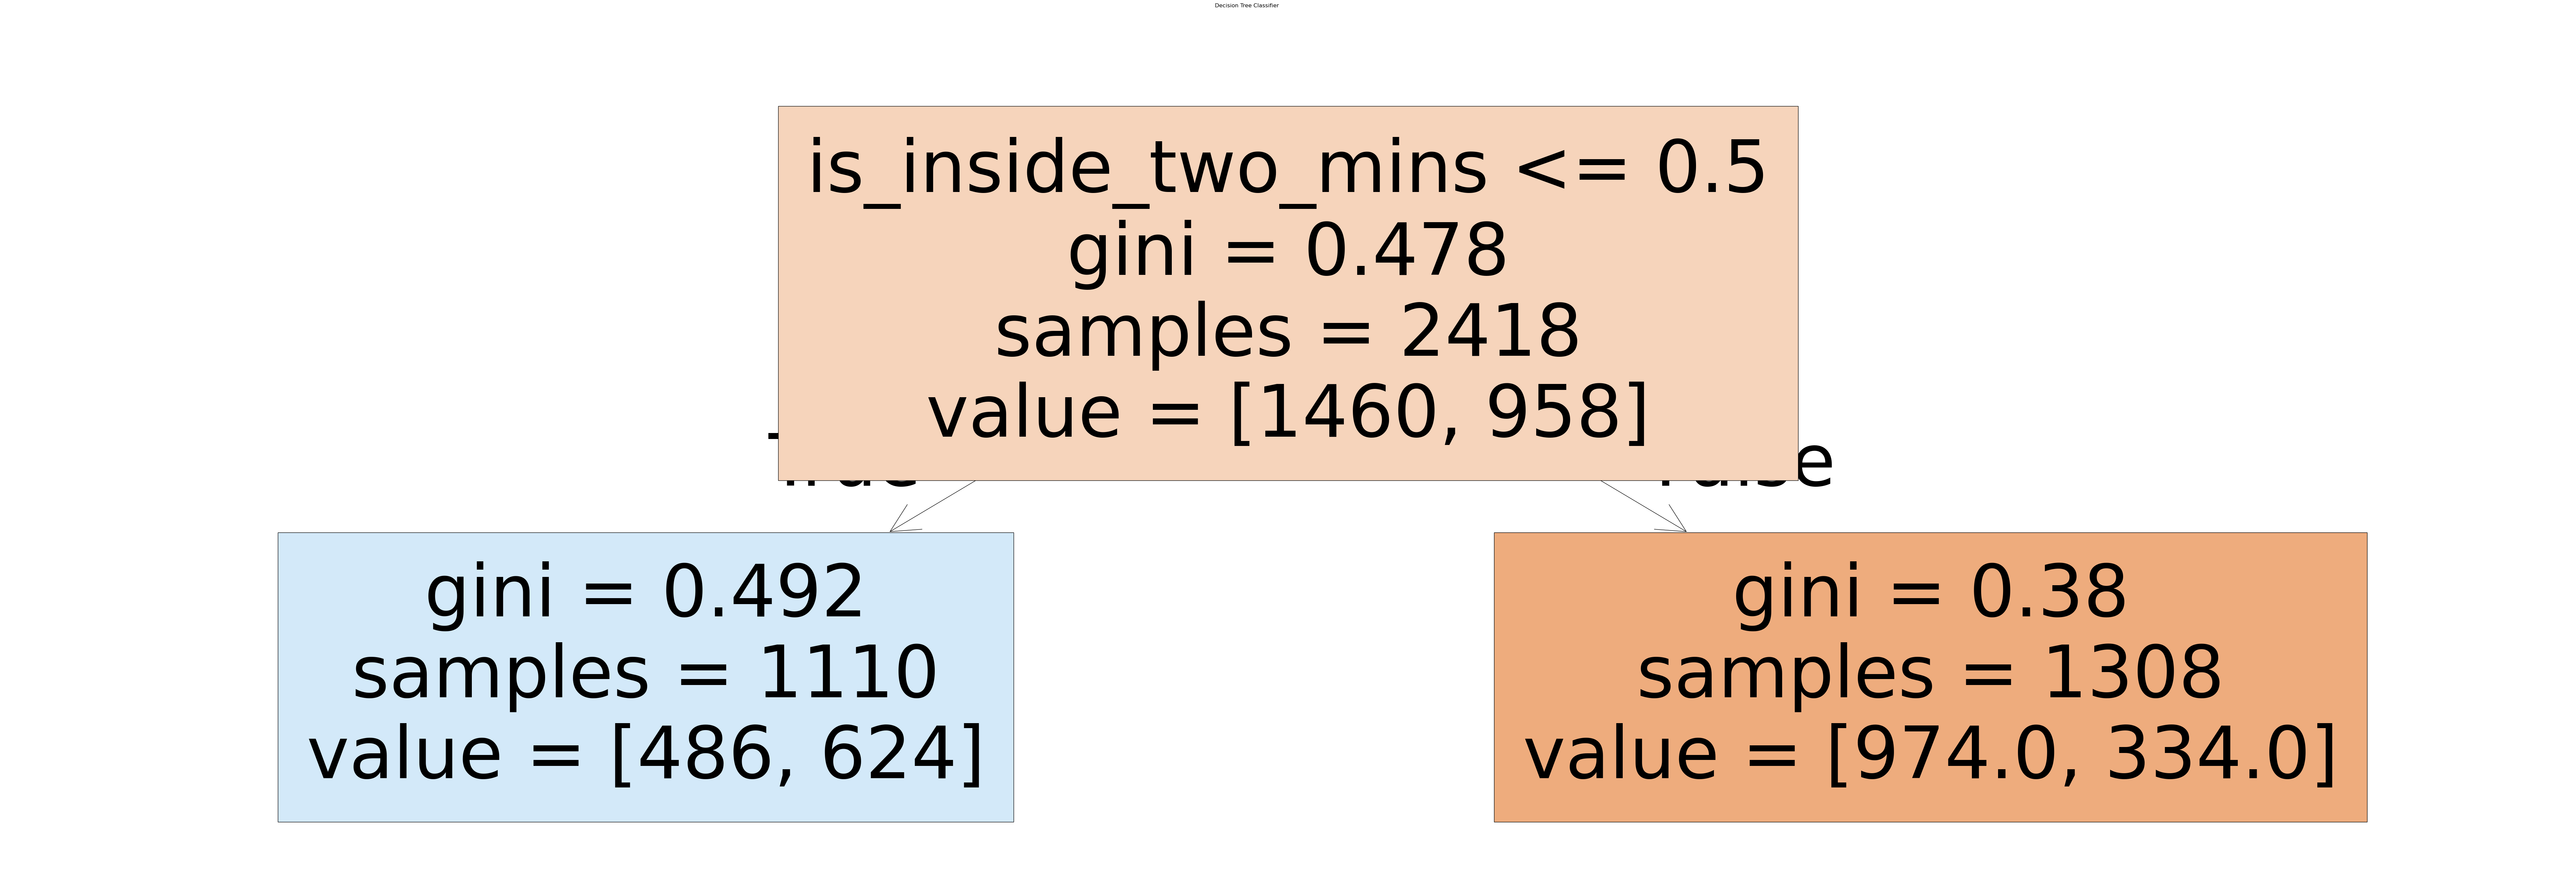

In [16]:
# for max_depth in range(1, 30):
model_name = f"DecisionTreeClassifier with (criterion={decision_tree__criterion}, max_depth={decision_tree__max_depth}, max_features={decision_tree__max_features})"
model = DecisionTreeClassifier(criterion=decision_tree__criterion, 
                                    max_depth=decision_tree__max_depth, 
                                    max_features=decision_tree__max_features)
ModelTrainer(model_name, 
            Pipeline([
                ('transformer', col_trans), 
                ('regression', model)
            ])).run()

# get cleaned up feature names
feature_names = []
feature_names += TRAINING_FEATURES
feature_names += col_trans.get_feature_names_out().tolist()
feature_names

feature_names = [x.replace('ordinalencoder__', '_').replace('onehotencoder__', '_').replace('remainder__', '_') for x in feature_names]

fig = plt.figure(figsize=(100,30))
_ = tree.plot_tree(model,
                   feature_names=feature_names,
                   filled=True)
plt.suptitle("Decision Tree Classifier")

### Support Vector Machines

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

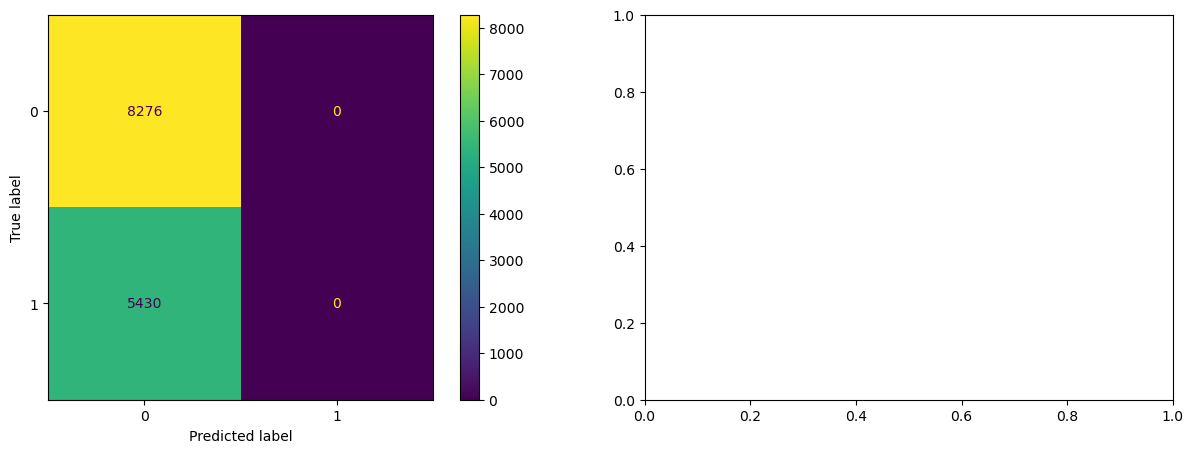

In [17]:
svc = SVC() #kernel=PARAM_SVM_KERNEL, gamma=PARAM_SVM_GAMMA, C=PARAM_SVM_C)

modeller = ModelTrainer(
    f"SVM (default params)",
    # f"SVM (kernel={PARAM_SVM_KERNEL}, gamma={PARAM_SVM_GAMMA}, C={PARAM_SVM_C})", 
    Pipeline([
        ('transformer', col_trans),
        ('regression', svc)
    ])
)
modeller.run()

### Ridge

In [ ]:
model_name = f"Ridge (alpha={alpha}) with StandardScaler"
model = Ridge(alpha=alpha)
ModelTrainer(model_name, 
             Pipeline([
                 ('transformer', col_trans), 
                 ('regression', model)
            ])).run()

NameError: name 'alpha' is not defined

# Summary

In [18]:
print_best_params("All Hyperparameters", all_best_params)
show_run_output()

*Best Run is 0.736466 from LogisticRegression (fit_intercept = True, penalty = None, C = 1.0, class_weight = None, solver = lbfgs)*

| Model | Features | Train Time | Train Accuracy | Test Accuracy |
| ----- | -------- | ---------- | -------------  | -----------   |
| Dummy | 0 | 0.0081 secs | 0.603805 | 0.603823 |
| LogisticRegression (fit_intercept = True, penalty = None, C = 1.0, class_weight = None, solver = lbfgs) | 11 | 0.0352 secs | 0.732423 | 0.736466 |
| K-Nearest Neighbors (algorithm = auto, n_neighbors = 1, weights = None) | 11 | 0.0590 secs | 0.990074 | 0.559463 |
| DecisionTreeClassifier with (criterion=gini, max_depth=1, max_features=None) | 11 | 0.0230 secs | 0.660877 | 0.664308 |
| SVM (default params) | 11 | 1.1560 secs | 0.603805 | 0.603823 |
